In [1]:
#extract dataset from kaggle
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
#download dataset
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:23<00:00, 152MB/s]
100% 1.14G/1.14G [00:24<00:00, 50.9MB/s]


In [3]:
#unzip folders and files
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
#defining directories for training testing and validation
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [6]:
batch_size = 16
img_height = 500
img_width = 500

In [7]:
#image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [8]:
type(train)

keras.preprocessing.image.DirectoryIterator

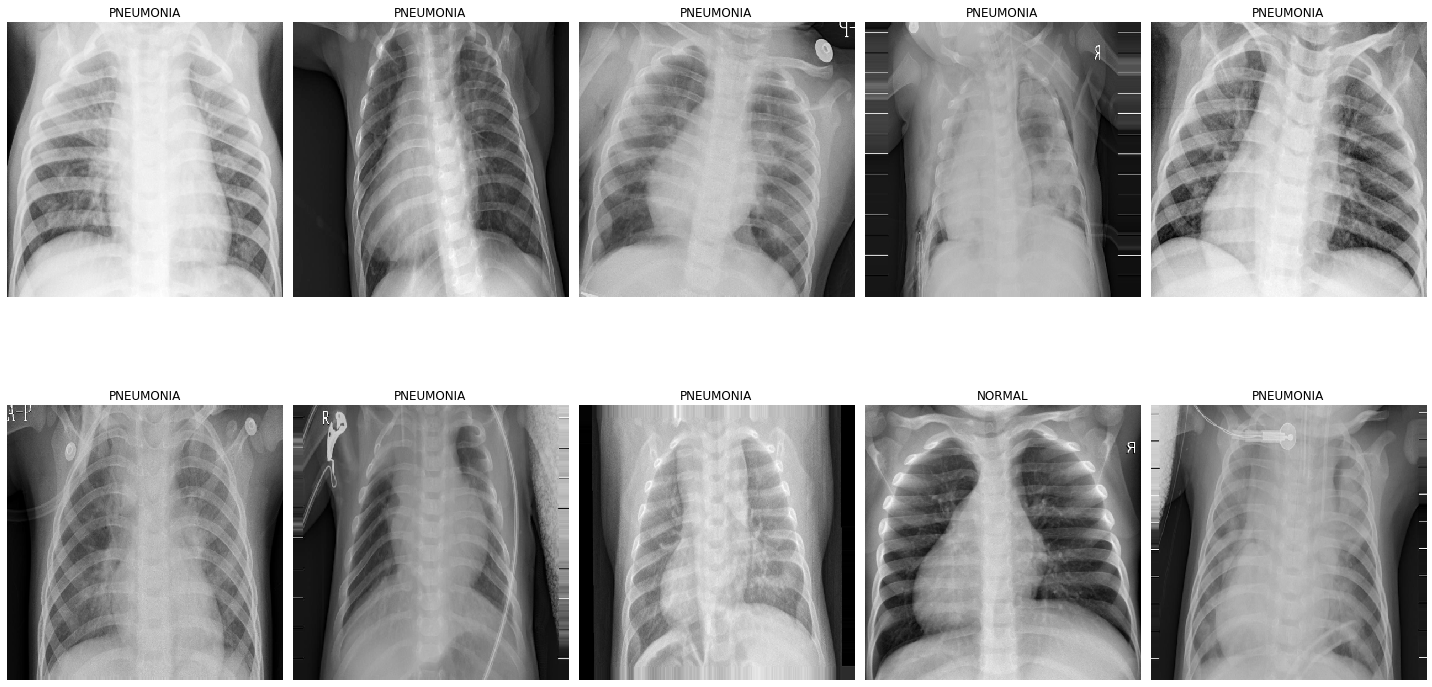

In [9]:
#train set images
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [11]:

#cnn architecture
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
#going deep in cnn model
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

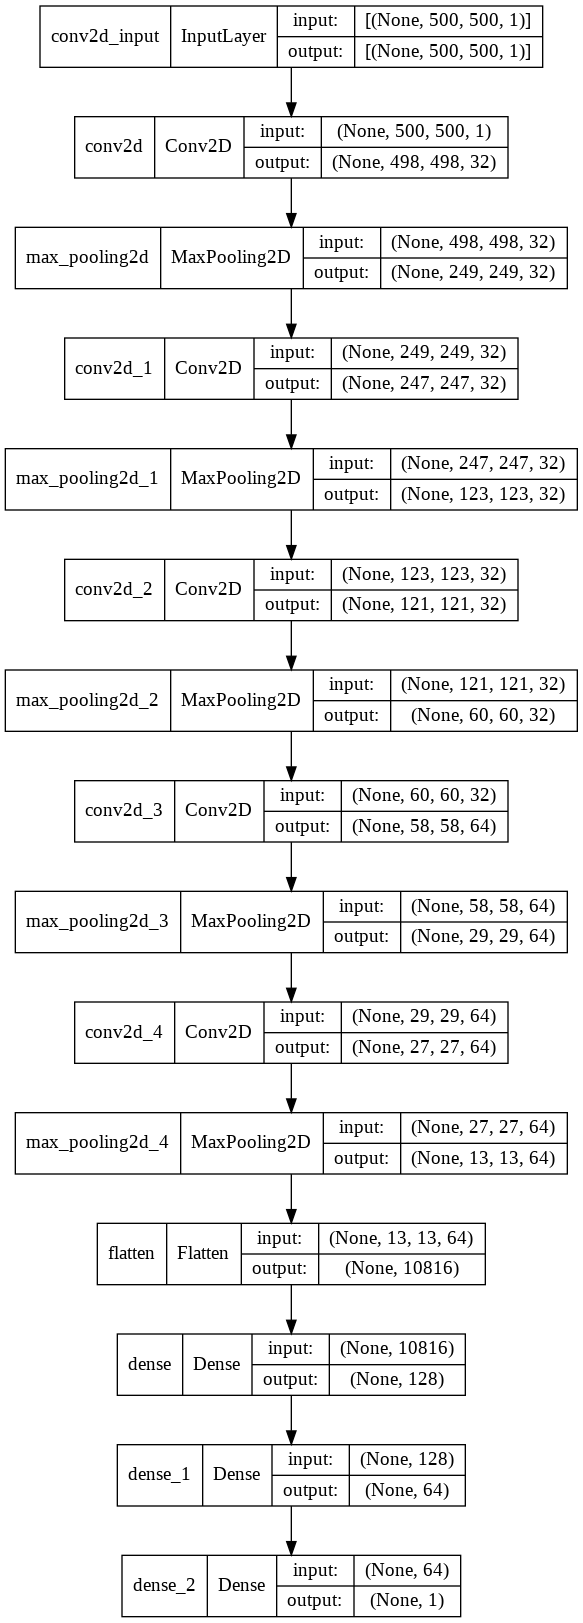

In [13]:
#visualize cnn model
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [14]:
#fit the model
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [15]:
#assigning class weights
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes                                                    
                                    )
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [16]:
#training
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
262/262 [==============================] - 148s 524ms/step - loss: 0.4487 - accuracy: 0.7739 - val_loss: 0.3553 - val_accuracy: 0.8731 - lr: 0.0010
Epoch 2/25
262/262 [==============================] - 130s 495ms/step - loss: 0.2361 - accuracy: 0.9048 - val_loss: 0.2612 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 3/25
262/262 [==============================] - 130s 496ms/step - loss: 0.2116 - accuracy: 0.9187 - val_loss: 0.1993 - val_accuracy: 0.9221 - lr: 0.0010
Epoch 4/25
262/262 [==============================] - 131s 500ms/step - loss: 0.1811 - accuracy: 0.9270 - val_loss: 0.1618 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 5/25
262/262 [==============================] - 130s 497ms/step - loss: 0.1730 - accuracy: 0.9313 - val_loss: 0.1834 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 6/25
262/262 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9306
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [====================

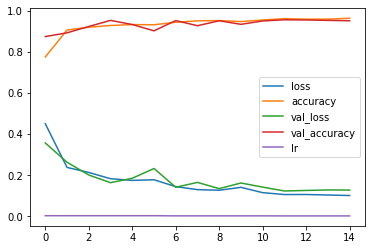

In [17]:
#evaluate
pd.DataFrame(cnn.history.history).plot()

In [18]:
#accuracy
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 6s 157ms/step - loss: 0.2500 - accuracy: 0.9263
The testing accuracy is : 92.62820482254028 %


In [19]:
#predict test dataset
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 6s 154ms/step


In [20]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [ ]:
#confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [22]:
#classification report
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.85      0.90       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [23]:
#visualize predicted images with %
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


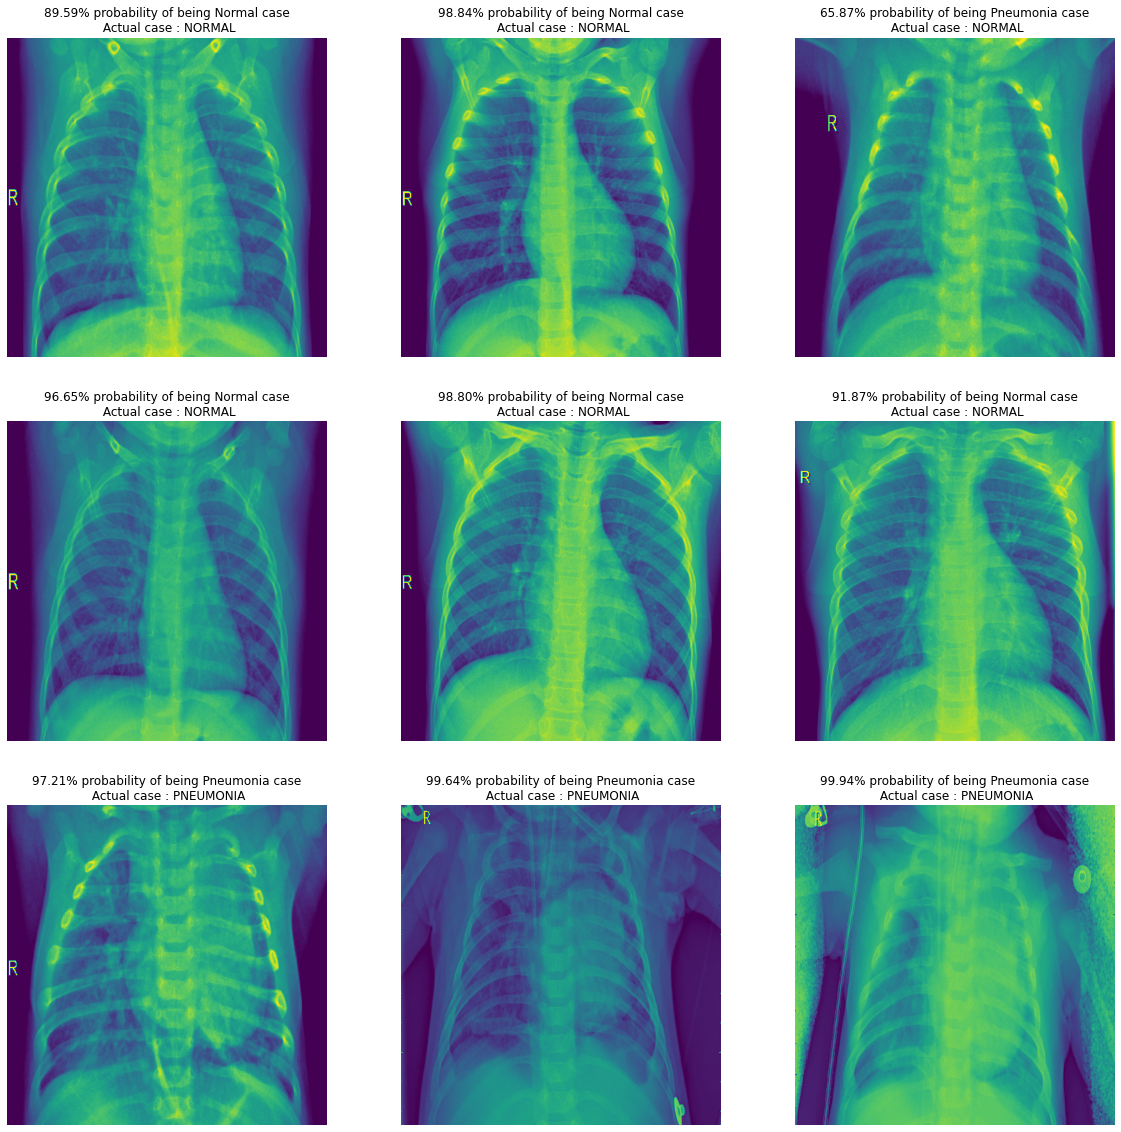

In [24]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

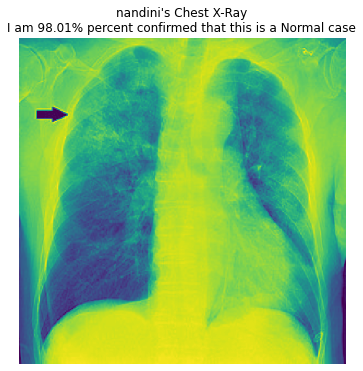

In [34]:
# Testing with my own Chest X-Ray
nandini_path = '/content/300px-Chest_radiograph_in_influensa_and_H_influenzae,_posteroanterior,_annotated.jpg'

from tensorflow.keras.preprocessing import image

nandini_img = image.load_img(nandini_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_nandini_img = image.img_to_array(nandini_img)
pp_nandini_img = pp_nandini_img/255
pp_nandini_img = np.expand_dims(pp_nandini_img, axis=0)

#predict
nandini_preds= cnn.predict(pp_nandini_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if nandini_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(nandini_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-nandini_preds[0][0]))
    

plt.title("nandini's Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_nandini_img))
plt.show()